In [2]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pipedream_solver.ngeometry
import scipy.optimize
import glob
import os
import geopandas as gpd

In [3]:
from muskingum import muskingum_matrix

In [4]:
with open('../DA-Routing/config/flowpaths.geojson') as carmel:
    d = json.load(carmel)

In [5]:
node_ids = [i['properties']['id'].replace('cat-', '') for i in d['features']]

In [6]:
link_ids = [i['properties']['id'].replace('cat-', '') for i in d['features']]
reach_ids = link_ids

In [7]:
source_node_ids = [i['properties']['id'].replace('cat-', '') for i in d['features']]
target_node_ids = [i['properties']['toid'].replace('nex-', '') for i in d['features']]

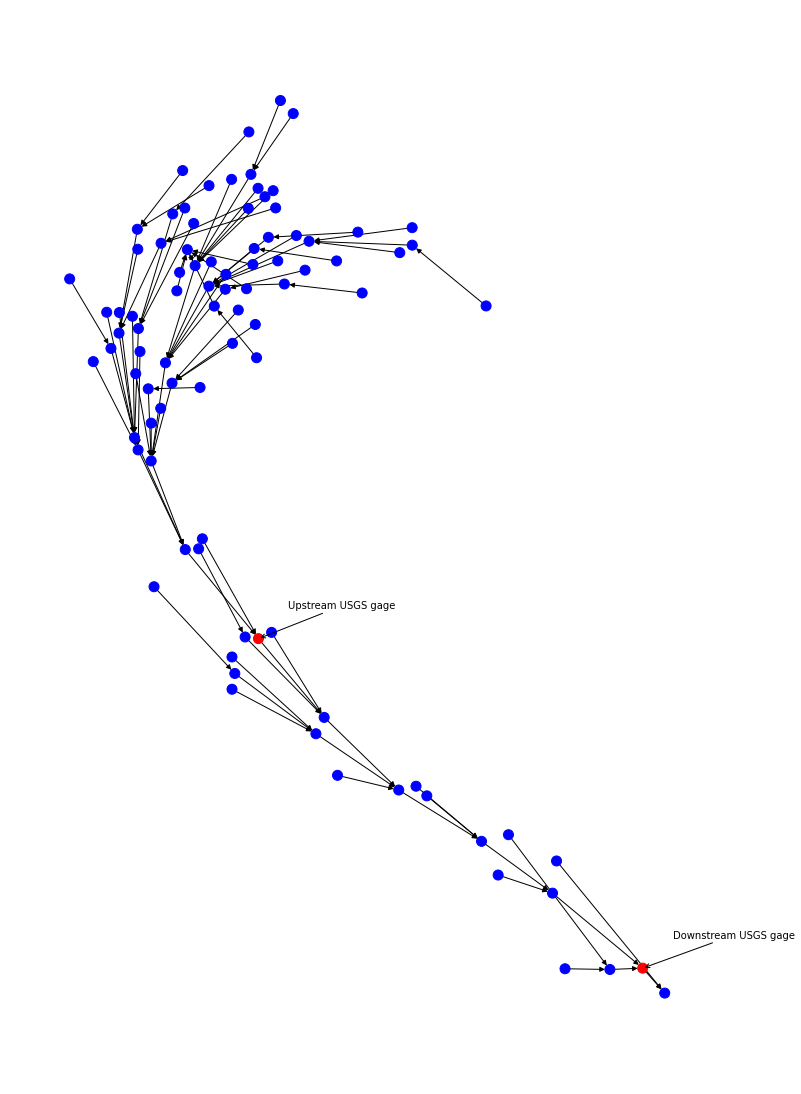

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

for i in range(len(source_node_ids)):
    G.add_edge(source_node_ids[i], target_node_ids[i])
upstream = '3400549'
downstream = '3400554'
colors = ['red' if node == upstream or node == downstream else 'blue' for node in G.nodes()]

plt.figure(figsize=(10, 15))

pos = nx.spring_layout(G, seed=0) 

nx.draw(G, pos, with_labels=False, node_color=colors, node_size=100, font_size=10)

node_position1 = pos[upstream] 
plt.annotate("Upstream USGS gage",  
             xy=node_position1,
             xytext=(30, 30),  
             textcoords='offset points',
             arrowprops=dict(facecolor='red', arrowstyle="->")) 

node_position2 = pos[downstream] 
plt.annotate("Downstream USGS gage",  
             xy=node_position2,
             xytext=(30, 30),  
             textcoords='offset points',
             arrowprops=dict(facecolor='red', arrowstyle="->")) 

plt.show()


In [9]:
dx = np.asarray([i['properties']['lengthkm'] for i in d['features']]) * 1000 # km to m

In [10]:
df = pd.read_csv('../DA-Routing/config/cfe_noahowp_attributes.csv')
So =  np.array(df['slope'])

In [11]:
roughness = np.ones(len(reach_ids)) * 0.05 

In [12]:
obs_point = source_node_ids.index('3400549')
downstream = source_node_ids.index('3400554')

In [13]:
drainage_area = np.asarray([i['properties']['tot_drainage_areasqkm'] for i in d['features']])

In [14]:
# channel geometry
Tws = []
Bws = []
dbs = []
inv_ms = []
for area in drainage_area:
    Tw = 2.44 * (area)**0.34
    A = 0.75*(area)**0.53
    db_rectangle = A / Tw  
    db_model = 10 * db_rectangle
    Bw = max(((2*A/db_model)-Tw), Tw/2)
    inv_m = (Tw-Bw)/(2*db_model)
    Tws.append(Tw)
    Bws.append(Bw)
    dbs.append(db_model)
    inv_ms.append(inv_m)
Tws = np.asarray(Tws)
Bws = np.asarray(Bws)
dbs = np.asarray(dbs)
inv_ms = np.asarray(inv_ms)

In [15]:
def normal_flow(h, Q, g1, g2, g3, phi, S_0, n):
    A = pipedream_solver.ngeometry.Trapezoidal_A_ik(h, h, g1, g2, g3)
    Pe = pipedream_solver.ngeometry.Trapezoidal_Pe_ik(h, h, g1, g2, g3)
    R = pipedream_solver.ngeometry.Trapezoidal_R_ik(A, Pe)
    Q_c = (phi * np.sqrt(S_0) / n) * A * R**(2/3)
    return Q_c - Q

# CFE output

In [16]:
files = glob.glob('../DA-Routing/output_decjanfeb_cfe_pet_carmel_classic/cat-*_output.csv')
df_all = pd.DataFrame()

for file in files:
    df = pd.read_csv(file, parse_dates=True)
    base = os.path.basename(file)
    id = os.path.splitext(base)[0].replace('cat-', '').replace('_output', '')
    df_all[id] = df['land_surface_water__runoff_volume_flux']

df_all.head()

,3400594,3400602,3400588,3400577,3400629,3400566,3400551,3400599,3400624,3400613,...,3400543,3400601,3400568,3400597,3400586,3400579,3400610,3400627,3400552,3400565
0,0.110810,0.102909,0.131720,0.460917,0.102221,0.234307,0.379389,0.156165,0.032823,0.064670,...,0.322003,0.151212,0.282275,0.178289,0.066021,0.300346,0.123295,0.126502,0.273242,0.340983
1,0.110807,0.102908,0.131714,0.460937,0.102213,0.234476,0.379404,0.156155,0.032822,0.064666,...,0.322014,0.151203,0.282367,0.178281,0.066018,0.300366,0.123295,0.126495,0.273248,0.341079
2,0.116150,0.107915,0.137037,0.483963,0.107660,0.246236,0.392233,0.162929,0.034415,0.067243,...,0.337563,0.157676,0.296632,0.187158,0.068796,0.315155,0.129490,0.132859,0.283627,0.358072
3,0.126441,0.117556,0.147281,0.528299,0.118169,0.268712,0.416852,0.175978,0.037485,0.072204,...,0.367491,0.170142,0.324016,0.204267,0.074144,0.343623,0.141424,0.145129,0.303572,0.390701
4,0.141304,0.131478,0.162057,0.592334,0.133368,0.301073,0.452294,0.194816,0.041921,0.079360,...,0.410699,0.188138,0.363518,0.228989,0.081861,0.384737,0.158666,0.162860,0.332316,0.437769


In [17]:
#df_all = df_all / 1000 # convert cmh to cms
CFE = df_all / 1 # CFE output is in cms

In [18]:
#plt.plot(CFE)

In [19]:
dt = 3600 # 1hr

# Routing without Data Assimilation

In [20]:
o_t_prev = CFE[reach_ids].iloc[0].values
O_t = [o_t_prev]

for t in range(len(CFE) - 1):
    q_t_next = CFE[reach_ids].iloc[t+1].values
    
    startnodes = np.asarray([node_ids.index(i) if i in node_ids
                         else -1 for i in source_node_ids])
    endnodes = np.asarray([node_ids.index(i) if i in node_ids 
                       else -1 for i in target_node_ids])

    self_loops = []

    for i in range(len(startnodes)):
        if endnodes[i] == -1:
            self_loops.append(i)
            endnodes[i] = startnodes[i]
        
    indegree = np.bincount(endnodes.ravel(), minlength=startnodes.size)

    for self_loop in self_loops:
        indegree[self_loop] -= 1

    hs = []
    As = []
    Rs = []
    Qs = []

    for Qi, db, Bw, inv_m, man_n, slope in zip(o_t_prev, dbs, Bws, inv_ms, roughness, So):
        result = scipy.optimize.root_scalar(normal_flow, args=(Qi, db, Bw, inv_m, 1., slope, man_n), 
                                        method='bisect', bracket=[0., db])
        
        h = max(result.root, 1e-2)
        A = pipedream_solver.ngeometry.Trapezoidal_A_ik(h, h, db, Bw, inv_m)
        Pe = pipedream_solver.ngeometry.Trapezoidal_Pe_ik(h, h, db, Bw, inv_m)
        R = pipedream_solver.ngeometry.Trapezoidal_R_ik(A, Pe)
        Q = np.sqrt(slope) / man_n * A * R**(2/3)
        hs.append(h)
        Rs.append(R)
        As.append(A)
        Qs.append(Q)
    
    hs = np.asarray(hs)
    Rs = np.asarray(Rs)
    As = np.asarray(As)
    Qs = np.asarray(Qs)

    ck = 1 * Qs / As
    K = np.maximum(dx / ck, 3600)
    X = np.minimum(np.maximum(0.5 * (1 - q_t_next / (So * ck * dx)), 0.2), 0.3)

    alpha = (dt + 2 * K * X) / (2 * K * (1 - X) + dt)
    beta = (dt - 2 * K * X) / (2 * K * (1 - X) + dt)
    chi = (2 * K * (1 - X) - dt) / (2 * K * (1 - X) + dt)
    gamma = dt / (K * (1 - X) + dt / 2)

    startnodes = startnodes[(indegree == 0)]
    
    A, B = muskingum_matrix(startnodes, endnodes, alpha, beta, chi, gamma, indegree)
    o_t_next = A @ o_t_prev + B @ q_t_next
    o_t_next = np.maximum(o_t_next, 0)
    O_t.append(o_t_next)
    o_t_prev = o_t_next
    
O_t_base = np.vstack(O_t)
O_t_base = pd.DataFrame(O_t)
O_t_base.columns = reach_ids
O_t_base.index = CFE.index

# Routing with Data Assimilation (Kalman filter)

In [21]:
import dataretrieval.nwis as nwis

/opt/homebrew/anaconda3/envs/pysheds/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [22]:
discharge = nwis.get_record(sites="11143200", parameterCd='00060',
                                start="2016-11-30", end="2017-02-27")
discharge = discharge.select_dtypes(include=['float64', 'int64']).resample('H').mean() # hourly averaged value

In [23]:
discharge['cms'] = discharge['00060'] / 35.315 # cfs to cms

In [24]:
n = len(source_node_ids)

In [25]:
V = 1 * np.eye(1)    # Measurement noise
W = 50 * np.eye(n)      # Process noise
S = 1 * np.eye(n)

In [26]:
C = np.zeros((1, n))
C[:,obs_point] = 1      # Observation point

In [27]:
o_t_prev = CFE[reach_ids].iloc[0].values
O_t = [o_t_prev]

ys = [C @ o_t_prev]

covariance_matrices = np.zeros((n, n, len(CFE)))
covariance_matrices[:, :, 0] = S

for t in range(len(CFE) - 1):
    q_t_next = CFE[reach_ids].iloc[t+1].values
    
    startnodes = np.asarray([node_ids.index(i) if i in node_ids
                         else -1 for i in source_node_ids])
    endnodes = np.asarray([node_ids.index(i) if i in node_ids 
                       else -1 for i in target_node_ids])

    self_loops = []

    for i in range(len(startnodes)):
        if endnodes[i] == -1:
            self_loops.append(i)
            endnodes[i] = startnodes[i]
        
    indegree = np.bincount(endnodes.ravel(), minlength=startnodes.size)

    for self_loop in self_loops:
        indegree[self_loop] -= 1

    hs = []
    As = []
    Rs = []
    Qs = []

    for Qi, db, Bw, inv_m, man_n, slope in zip(o_t_prev, dbs, Bws, inv_ms, roughness, So):
        result = scipy.optimize.root_scalar(normal_flow, args=(Qi, db, Bw, inv_m, 1., slope, man_n), 
                                        method='bisect', bracket=[0., db])
        
        h = max(result.root, 1e-2)
        A = pipedream_solver.ngeometry.Trapezoidal_A_ik(h, h, db, Bw, inv_m)
        Pe = pipedream_solver.ngeometry.Trapezoidal_Pe_ik(h, h, db, Bw, inv_m)
        R = pipedream_solver.ngeometry.Trapezoidal_R_ik(A, Pe)
        Q = np.sqrt(slope) / man_n * A * R**(2/3)
        hs.append(h)
        Rs.append(R)
        As.append(A)
        Qs.append(Q)
    
    hs = np.asarray(hs)
    Rs = np.asarray(Rs)
    As = np.asarray(As)
    Qs = np.asarray(Qs)

    ck = 1. * Qs / As
    K = np.maximum(dx / ck, 3600)
    X = np.minimum(np.maximum(0.5 * (1 - q_t_next / (So * ck * dx)), 0.2), 0.3)

    alpha = (dt + 2 * K * X) / (2 * K * (1 - X) + dt)
    beta = (dt - 2 * K * X) / (2 * K * (1 - X) + dt)
    chi = (2 * K * (1 - X) - dt) / (2 * K * (1 - X) + dt)
    gamma = dt / (K * (1 - X) + dt / 2)

    startnodes = startnodes[(indegree == 0)]
    
    A, B = muskingum_matrix(startnodes, endnodes, alpha, beta, chi, gamma, indegree)
    
    xbar = A @ o_t_prev + B @ q_t_next
    Pbar = A @ S @ A.T + W

    ## USGS observation
    y = discharge['cms'][t+16]
    ys.append(y)

    L = Pbar @ C.T @ np.linalg.inv( C @ Pbar @ C.T + V )
    S = (np.eye(len(Pbar)) - L @ C) @ Pbar
    o_t_next = xbar + L @(y - C @ xbar)

    O_t.append(o_t_next)
    o_t_prev = o_t_next
    o_t_prev = np.maximum(o_t_prev, 0)

    covariance_matrices[:, :, t+1] = S
    
O_t_DA = np.vstack(O_t)
O_t_DA = pd.DataFrame(O_t)
O_t_DA.columns = reach_ids
O_t_DA.index = CFE.index

In [28]:
# uncertaitny boudns
standard_deviations = np.zeros((n, len(CFE)))
for t in range(1, len(CFE)):
    standard_deviations[:, t] = np.sqrt(np.diag(covariance_matrices[:, :, t]))

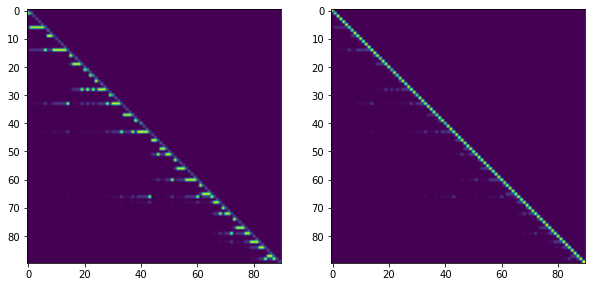

In [29]:
# A and B matrix for state space euqation at the final step.
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(A)
ax[1].imshow(B)

In [30]:
sns.set_palette('husl', n)

/opt/homebrew/anaconda3/envs/pysheds/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


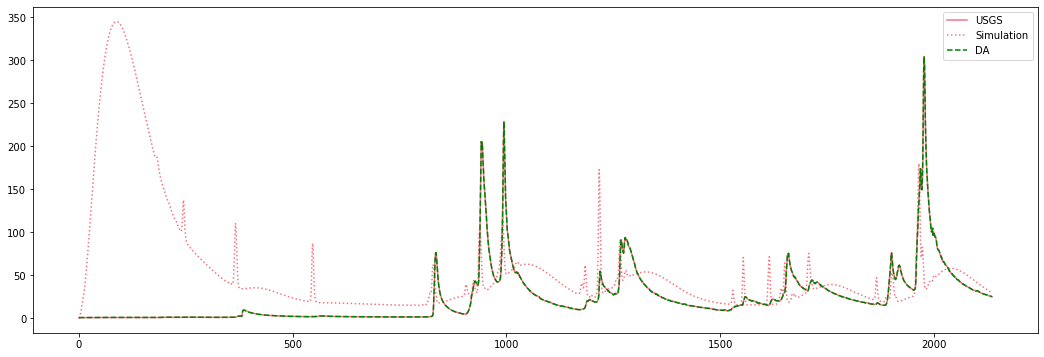

In [31]:
# Raw Simulations, Use December as warm-up period.
fig, ax = plt.subplots(figsize=(18, 6))
plt.plot(ys, label = 'USGS')
plt.plot(O_t_base.iloc[:,obs_point], ':', label = 'Simulation')
plt.plot(O_t_DA.iloc[:,obs_point], '--', color = 'green', label = 'DA')
plt.legend()

# Ungauged location 

In [32]:
discharge_dw = nwis.get_record(sites="11143250", parameterCd='00060',
                                start="2016-11-30", end="2017-02-27")
discharge_dw = discharge_dw.select_dtypes(include=['float64', 'int64']).resample('H').mean()
discharge_dw['cms'] = discharge_dw['00060'] / 35.315

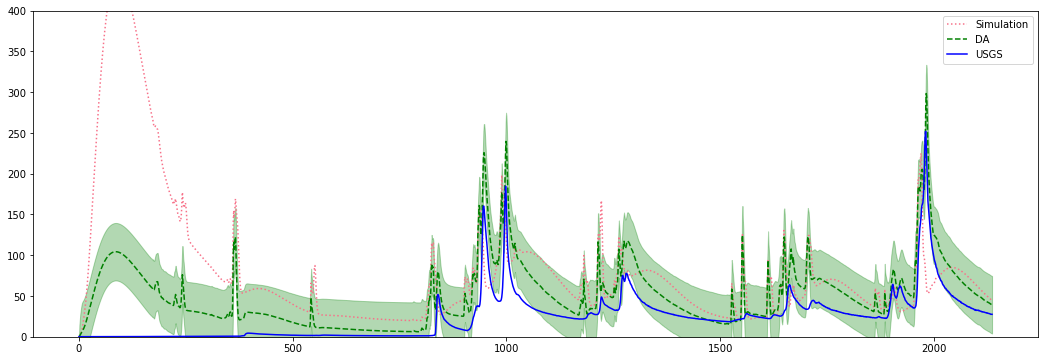

In [33]:
fig, ax = plt.subplots(figsize=(18, 6))
plt.plot(O_t_base.iloc[:,downstream], ':', label = 'Simulation')
plt.plot(O_t_DA.iloc[:,downstream], '--', color = 'green', label = 'DA')
plt.plot(discharge_dw['cms'][16:-7].values, color = 'blue', label = 'USGS')
plt.fill_between(np.arange(len(CFE)), O_t_DA.iloc[:,downstream] - 1.96 * standard_deviations[downstream,:], 
        O_t_DA.iloc[:,downstream] + 1.96 * standard_deviations[downstream,:], color = 'green', alpha=0.3)
#plt.xlim([800,1500])
plt.ylim([0,400])
plt.legend()

# Comparison with NWM

In [34]:
import xarray as xr
import fsspec

In [35]:
nwm_uri = 's3://noaa-nwm-retrospective-2-1-zarr-pds/chrtout.zarr'
ds = xr.open_zarr(fsspec.get_mapper(nwm_uri, anon=True, requester_pays=True))

In [36]:
reach_ids = 17599295 ### checked

start_time = '2016-12-01T00:00:00'
end_time = '2017-02-28T00:00:00'

sub_ds = ds.sel(feature_id=reach_ids, time=slice(start_time, end_time))
nwm_downstream = sub_ds.streamflow.values

In [37]:
reach_ids = 17600477 ### checked

start_time = '2016-12-01T00:00:00'
end_time = '2017-02-28T00:00:00'

sub_ds = ds.sel(feature_id=reach_ids, time=slice(start_time, end_time))
nwm_upstream = sub_ds.streamflow.values

In [38]:
# dimension check
print(nwm_upstream.shape)
print(nwm_downstream.shape)
print(O_t_base.shape)
print(discharge_dw['cms'][16:-7].shape)

(2137,)
(2137,)
(2137, 90)
(2137,)


# Plotting

In [39]:
#discharge_dw['cms'][16:-7].index

/opt/homebrew/anaconda3/envs/pysheds/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


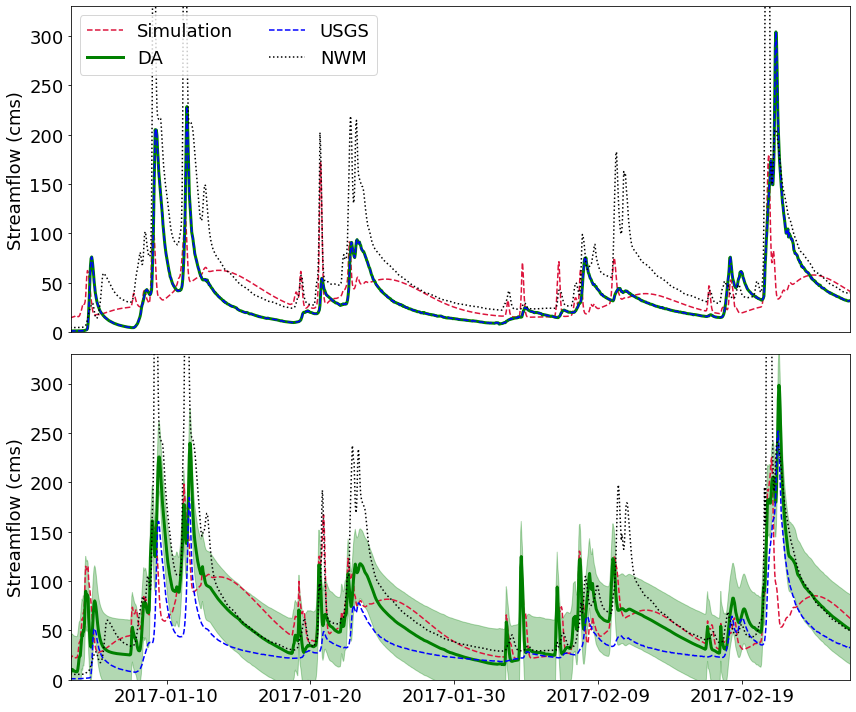

In [40]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

# Upstrem USGS (Data assimilation point)
axs[0].plot(O_t_base.iloc[:,obs_point], '--', color = 'crimson', label = 'Simulation')
axs[0].plot(O_t_DA.iloc[:,obs_point], color = 'green', label = 'DA', linewidth = 3)
axs[0].plot(ys, '--', color = 'blue', label = 'USGS')
axs[0].plot(nwm_upstream, ':', color = 'black', label = 'NWM')

labels = [label.strftime('%Y-%m-%d') for label in discharge_dw['cms'][16:-7].index]
n = 240  # Select every nth timestamp for display
selected_indices = range(0, len(discharge_dw['cms'][16:-7]), n)
selected_labels = [labels[i] for i in selected_indices]

axs[0].set_xticks([])
axs[0].set_ylabel('Streamflow (cms)', fontsize=18)
axs[0].set_ylim([0, 330])
axs[0].set_xlim([800, 2100])
axs[0].tick_params(labelsize=18)
axs[0].legend(fontsize=18, loc='upper left', ncol=2)

# Downstream USGS (Ungauged point)
axs[1].plot(O_t_base.iloc[:,downstream], '--', color = 'crimson', label = 'Simulation')
axs[1].plot(O_t_DA.iloc[:,downstream], color = 'green', label = 'DA', linewidth = 3)
axs[1].plot(discharge_dw['cms'][16:-7].values, '--', color = 'blue', label = 'USGS')
axs[1].plot(nwm_downstream, ':', color = 'black', label = 'NWM')

axs[1].fill_between(np.arange(len(CFE)), O_t_DA.iloc[:,downstream] - 1.96 * standard_deviations[downstream,:], 
        O_t_DA.iloc[:,downstream] + 1.96 * standard_deviations[downstream,:], color = 'green', alpha=0.3, label = '95% confidence interval')

#axs[1].legend(fontsize=18, loc='upper left')

axs[1].set_xticks(selected_indices)
axs[1].set_xticklabels(selected_labels, fontsize=18) 
axs[1].set_ylabel('Streamflow (cms)', fontsize=18)
axs[1].set_ylim([0, 330])
axs[1].set_xlim([800, 2100])
axs[1].tick_params(labelsize=18)

plt.tight_layout()
plt.show()

In [41]:
# Root Mean Square Error
def rmse(actual, predicted):
    return np.sqrt(np.mean((actual - predicted) ** 2))

# Nash-Sutcliffe Efficiency
def nse(actual, predicted):
    return 1 - np.sum((actual - predicted) ** 2) / np.sum((actual - np.mean(actual)) ** 2)

# Kling-Gupta Efficiency
def kge(actual, predicted):
    r = np.corrcoef(actual, predicted)[0, 1]
    alpha = np.std(predicted) / np.std(actual)
    beta = np.mean(predicted) / np.mean(actual)
    return 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)

In [42]:
#discharge_dw['cms'][16 +800:-7 - 37]

In [43]:
reach_ids = 17599295 ### checked
start_time = '2017-01-03T08:00:00'
end_time = '2017-02-26T11:00:00'
sub_ds = ds.sel(feature_id=reach_ids, time=slice(start_time, end_time))
nwm_downstream_eval = sub_ds.streamflow.values

In [44]:
simulation = O_t_base.iloc[800:2100,downstream]
da = O_t_DA.iloc[800:2100,downstream]
nwm = nwm_downstream_eval

# ground truth
usgs = discharge_dw['cms'][16 +800:-7 - 37].values

# Calculate the error metrics for each model
rmse_sim = rmse(usgs, simulation)
rmse_da = rmse(usgs, da)
rmse_nwm = rmse(usgs, nwm)

nse_sim = nse(usgs, simulation)
nse_da = nse(usgs, da)
nse_nwm = nse(usgs, nwm)

kge_sim = kge(usgs, simulation)
kge_da = kge(usgs, da)
kge_nwm = kge(usgs, nwm)

# Combine the results into a dataframe for easy plotting
data = {
    'Simulation': [rmse_sim, nse_sim, kge_sim],
    'NWM': [rmse_nwm, nse_nwm, kge_nwm],
    'DA': [rmse_da, nse_da, kge_da],
}
df = pd.DataFrame(data, index=['RMSE', 'NSE', 'KGE'])

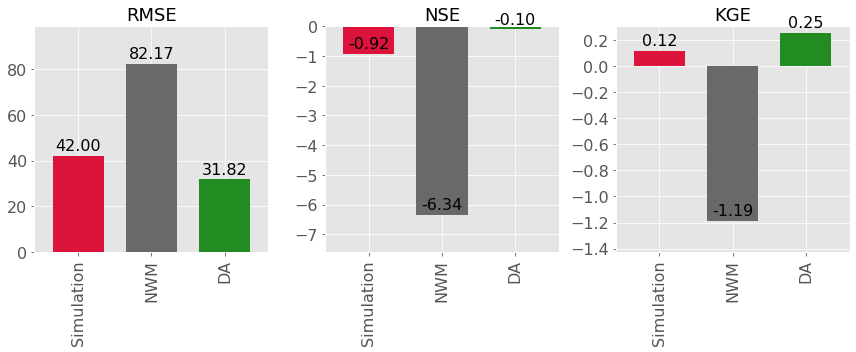

In [45]:
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

colors = ['crimson', 'dimgray', 'forestgreen']
metrics = ['RMSE', 'NSE', 'KGE']

for i, metric in enumerate(metrics):
    df.loc[metric].plot(kind='bar', ax=ax[i], color=colors, width=0.7, fontsize = 16)
    ax[i].set_title(metric, fontsize=18)
    ax[i].set_ylim([min(df.values[i].min() * 1.2, 0), max(df.values[i].max() *1.2, 0)]) 
    for p in ax[i].patches:
        ax[i].annotate(f'{p.get_height():.2f}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', 
                       va = 'center', 
                       xytext = (0, 10), 
                       textcoords = 'offset points',
                       fontsize=16,
                       )
plt.tight_layout()
plt.show()

# Plot for the watershed

In [46]:
import warnings
warnings.filterwarnings("ignore")

In [47]:
from pyproj import CRS, Transformer
map_crs = CRS("EPSG:5070")
sensor_crs = CRS("EPSG:4269")
transformer = Transformer.from_crs(sensor_crs, map_crs)

# downstream sensor location
longitude = -121.8805084
latitude = 36.5391278
down_latitude_transformed, down_longitude_transformed = transformer.transform(latitude, longitude)


In [48]:
# upstream sensor location
longitude = -121.7288889
latitude = 36.4748611
up_latitude_transformed, up_longitude_transformed = transformer.transform(latitude, longitude)

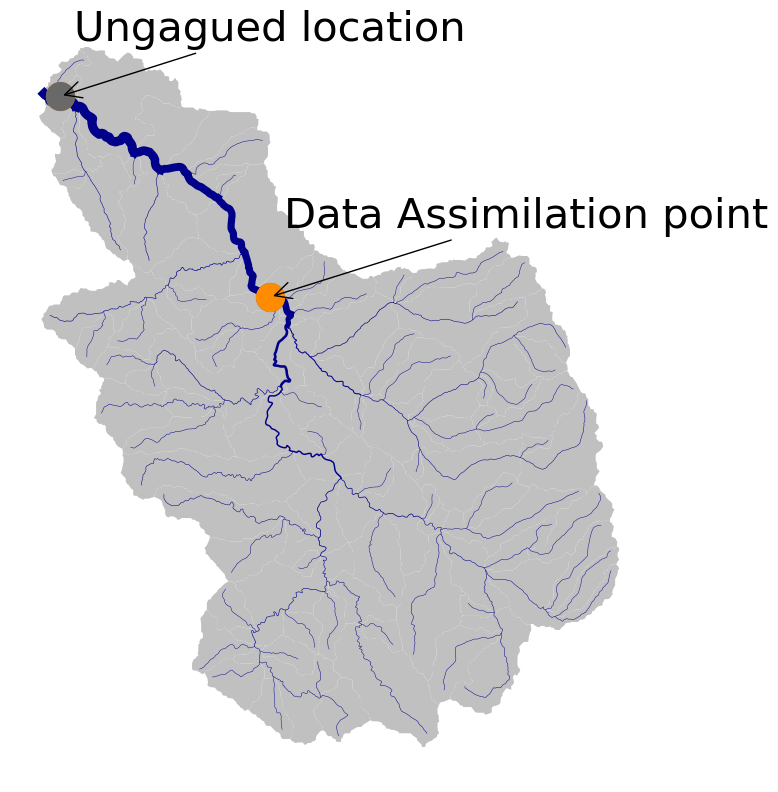

In [55]:
from shapely.geometry import MultiLineString
from sklearn.preprocessing import MinMaxScaler
plt.style.use('default')

# Load the flowrate data
flowrate_series = O_t_DA.iloc[950,:]
flowrates = flowrate_series.reset_index()
flowrates.columns = ['reach_id', 'flowrate']
# Convert 'reach_id' column to string
flowrates['reach_id'] = flowrates['reach_id'].astype(str)

# Load the GeoJSON data
flowlines = gpd.read_file('../DA-Routing/config/flowpaths.geojson')
catchments = gpd.read_file('../DA-Routing/config/catchments.geojson')

# Remove the 'cat-' prefix from the 'id' column
flowlines['id'] = flowlines['id'].str.replace('cat-', '')

# Merge the flowrate data with the GeoJSON data
flowlines = flowlines.merge(flowrates, left_on='id', right_on='reach_id')

# Fit the MinMaxScaler to the entire time series of flowrate values
scaler = MinMaxScaler(feature_range=(0.1, 10))
scaler.fit(O_t_DA.values.reshape(-1, 1))  # Fit on entire series

# Transform the flowrate values for the current timestep
flowlines['flowrate_scaled'] = scaler.transform(flowlines[['flowrate']])

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Set background to transparent
fig.patch.set_visible(False)
ax.axis('off')

# Plot the catchments first (background)
catchments.plot(ax=ax, color='silver')

# Plot each flowline with linewidth corresponding to the flowrate
for idx, row in flowlines.iterrows():
    linewidth = row['flowrate_scaled']
    if isinstance(row['geometry'], MultiLineString):
        for line in row['geometry']:
            x, y = line.xy
            ax.plot(x, y, linewidth=linewidth, color='darkblue') 
    else: # assuming the geometry is a LineString
        x, y = row['geometry'].xy
        ax.plot(x, y, linewidth=linewidth, color='darkkblue') 

ax.plot(down_latitude_transformed, down_longitude_transformed, marker='o', color='darkorange', markersize=20)
ax.plot(up_latitude_transformed, up_longitude_transformed, marker='o', color='dimgrey', markersize = 20)

ax.plot(down_latitude_transformed, down_longitude_transformed, marker='o', color='dimgrey', markersize=20)
ax.plot(up_latitude_transformed, up_longitude_transformed, marker='o', color='darkorange', markersize = 20)

node_position1 = (up_latitude_transformed, up_longitude_transformed)
plt.annotate("Data Assimilation point",  
             xy=node_position1,
             xytext=(10, 50),  
             textcoords='offset points',
             arrowprops=dict(facecolor='red', arrowstyle="->"),
             fontsize=30)

node_position2 = (down_latitude_transformed, down_longitude_transformed)
plt.annotate("Ungagued location",  
             xy=node_position2,
             xytext=(10, 40),  
             textcoords='offset points',
             arrowprops=dict(facecolor='red', arrowstyle="->"),
             fontsize=30) 

ax.axis('off')
plt.show()


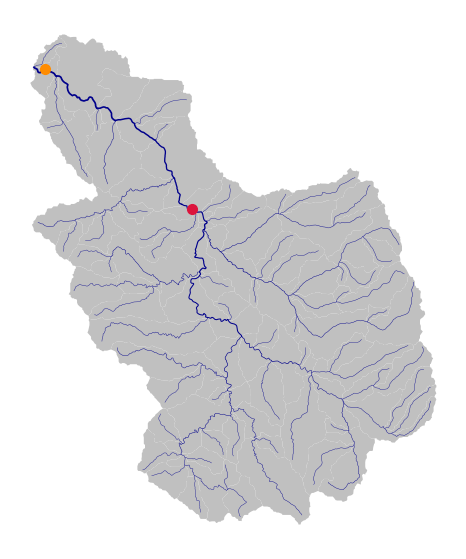

In [58]:
# import matplotlib.animation as animation
# O_t_DA = O_t_DA.iloc[800:1500,:]

# # Load the GeoJSON data
# flowlines_init = gpd.read_file('../DA-Routing/config/flowpaths.geojson')
# catchments = gpd.read_file('../DA-Routing/config/catchments.geojson')

# # Remove the 'cat-' prefix from the 'id' column
# flowlines_init['id'] = flowlines_init['id'].str.replace('cat-', '')

# # Initialize the figure
# fig, ax = plt.subplots(figsize=(7, 7))

# # Set background to transparent
# fig.patch.set_visible(False)
# ax.axis('off')

# # Plot the catchments first (background)
# catchments.plot(ax=ax, color='silver')

# # Fit the MinMaxScaler to the entire time series of flowrate values
# scaler = MinMaxScaler(feature_range=(0.1, 15))
# scaler.fit(O_t_DA.values.reshape(-1, 1))  # Fit on entire series

# lines = []
# for idx, row in flowlines_init.iterrows():
#     if isinstance(row['geometry'], MultiLineString):
#         for line in row['geometry']:
#             x, y = line.xy
#             lines.append(ax.plot(x, y, color='darkblue'))  # Using a fixed color for all lines
#     else:  # assuming the geometry is a LineString
#         x, y = row['geometry'].xy
#         lines.append(ax.plot(x, y, color='darkblue'))  # Using a fixed color for all lines

# def animate(i):
#     flowlines = flowlines_init.copy()  # Use a copy of the original flowlines data
#     flowrate_series = O_t_DA.iloc[i,:]
#     flowrates = flowrate_series.reset_index()
#     flowrates.columns = ['reach_id', 'flowrate']
#     flowrates['reach_id'] = flowrates['reach_id'].astype(str)
#     flowlines = flowlines.merge(flowrates, left_on='id', right_on='reach_id')
#     flowlines['flowrate_scaled'] = scaler.transform(flowlines[['flowrate']])
    
#     for idx, row in flowlines.iterrows():
#         linewidth = row['flowrate_scaled']
#         lines[idx][0].set_linewidth(linewidth)

# ax.plot(down_latitude_transformed, down_longitude_transformed, marker='o', color='darkorange', markersize=7)
# ax.plot(up_latitude_transformed, up_longitude_transformed, marker='o', color='crimson', markersize = 7)

# # node_position1 = (up_latitude_transformed, up_longitude_transformed)
# # plt.annotate("Upstream USGS gage",  
# #              xy=node_position1,
# #              xytext=(30, 40),  
# #              textcoords='offset points',
# #              arrowprops=dict(facecolor='red', arrowstyle="->")) 

# # node_position2 = (down_latitude_transformed, down_longitude_transformed)
# # plt.annotate("Downstream USGS gage",  
# #              xy=node_position2,
# #              xytext=(10, 40),  
# #              textcoords='offset points',
# #              arrowprops=dict(facecolor='red', arrowstyle="->")) 

# ax.axis('off')

# ani = animation.FuncAnimation(fig, animate, frames=len(O_t_DA), interval=10, blit=False)
# ani.save('animation.mp4', writer='ffmpeg')


In [59]:
# from moviepy.editor import VideoFileClip

# clip = VideoFileClip("animation.mp4")
# clip.write_gif("animation.gif")

MoviePy - Building file animation.gif with imageio.
